# Read in the file and drop NULL data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX



dafr = pd.read_csv('teleco_time_series.csv')

dafr.dropna()
dafr = dafr[dafr['Revenue']> 0]

dafr['Date'] = pd.date_range(start = datetime(2020,1,1),periods = dafr.shape[0],freq='24H')
dafr = dafr.set_index(['Date'])

dafr = dafr.drop(['Day'],axis = 1)
dafr.shape

(730, 1)

# Plot of revenue in millions from Jan 2020 to Jan 2022

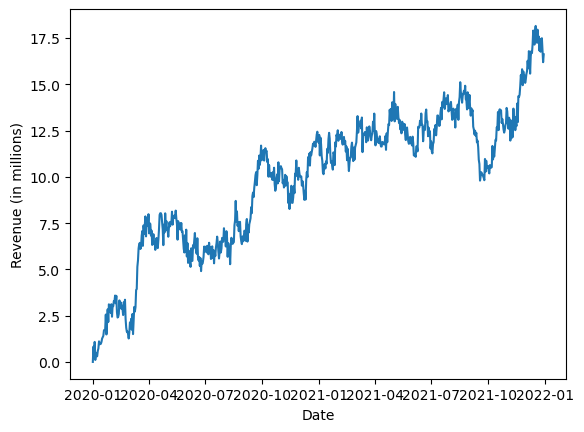

In [2]:
plt.xlabel('Date')
plt.ylabel('Revenue ''(in millions)''')
plt.plot(dafr)

# Dickey Fuller test

In [3]:
from statsmodels.tsa.stattools import adfuller
print ('Dickey-Fuller test: ')

dfte = adfuller(dafr['Revenue'], autolag='AIC')
dfout = pd.Series(dfte[0:4], index=['Test Statistic','pvalue','#Lags','No.Observations'])

for key,value in dfte[4].items():
	dfout['Critical Value (%s) '%key] = value # Critical Values should always be more than the test statistic

print(dfout)

Dickey-Fuller test: 
Test Statistic            -1.774638
pvalue                     0.393124
#Lags                      1.000000
No.Observations          728.000000
Critical Value (1%)       -3.439364
Critical Value (5%)       -2.865518
Critical Value (10%)      -2.568888
dtype: float64


In [4]:
df_stationarity = dafr.diff().dropna()

In [5]:
from statsmodels.tsa.stattools import adfuller
print ('Dickey-Fuller test: ')

dfte = adfuller(dafr['Revenue'], autolag='AIC')
dfout = pd.Series(dfte[0:4], index=['Test Statistic','pvalue','#Lags','No.Observations'])

for key,value in dfte[4].items():
	dfout['Critical Value (%s) '%key] = value # Critical Values should always be more than the test statistic

print(dfout)

Dickey-Fuller test: 
Test Statistic            -1.774638
pvalue                     0.393124
#Lags                      1.000000
No.Observations          728.000000
Critical Value (1%)       -3.439364
Critical Value (5%)       -2.865518
Critical Value (10%)      -2.568888
dtype: float64


# Split of test set and training set

In [6]:
Xtrain = df_stationarity.iloc[:-145]
Xtest = df_stationarity.iloc[-145:]

print("X_train shape: ",Xtrain.shape)
print("X_test shape: ",Xtest.shape)

X_train shape:  (584, 1)
X_test shape:  (145, 1)


In [7]:
df_stationarity.to_csv("cleaned_D213.csv")
Xtrain.to_csv('X_train.csv')
Xtest.to_csv('X_test.csv')

# Decomposition (Seasonality, Trend)

In [8]:
decom = seasonal_decompose(dafr['Revenue'], period=90)



<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date'>

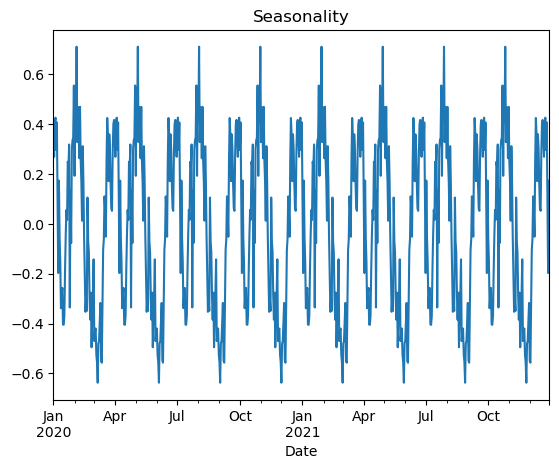

In [9]:
plt.title('Seasonality')
decom.seasonal.plot()


<AxesSubplot:title={'center':'Trend'}, xlabel='Date'>

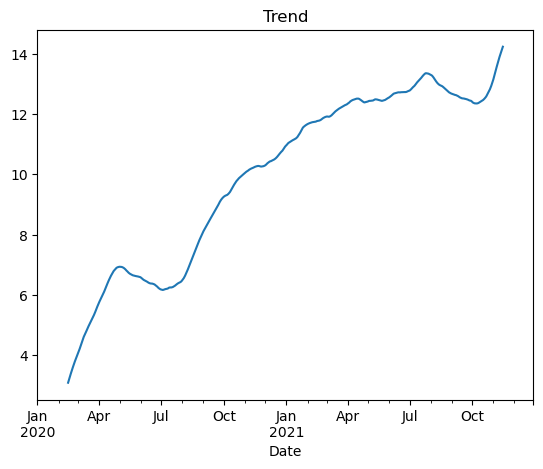

In [10]:
plt.title('Trend')
decom.trend.plot()


# Autocorrelation(acf,pacf)

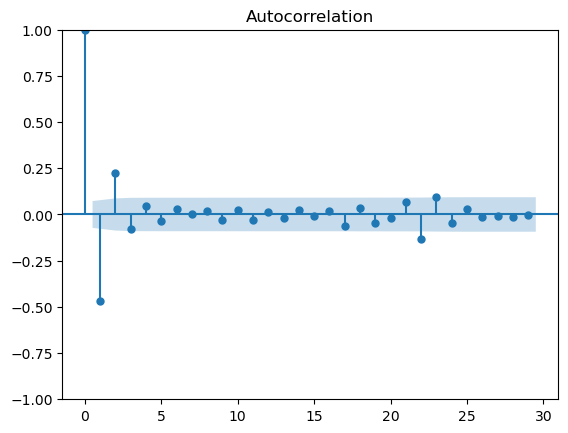

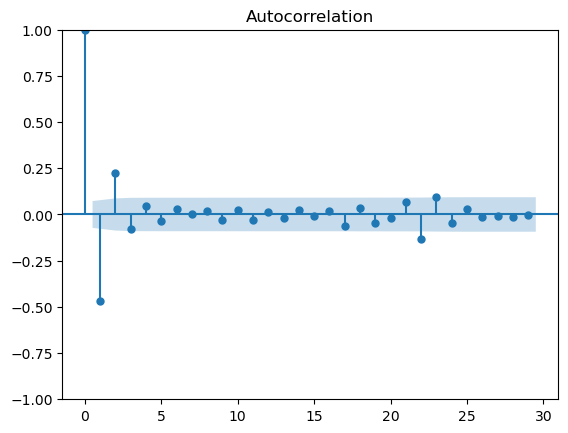

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_stationarity)

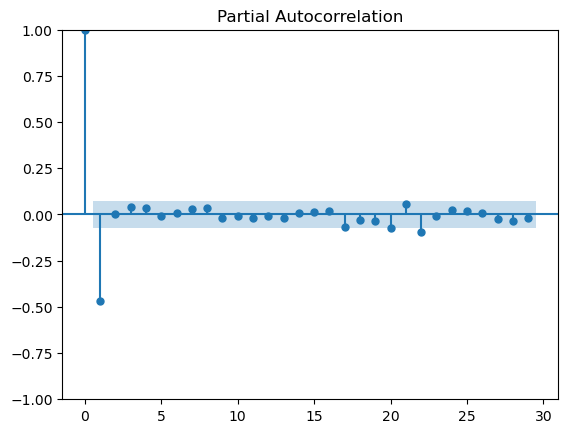

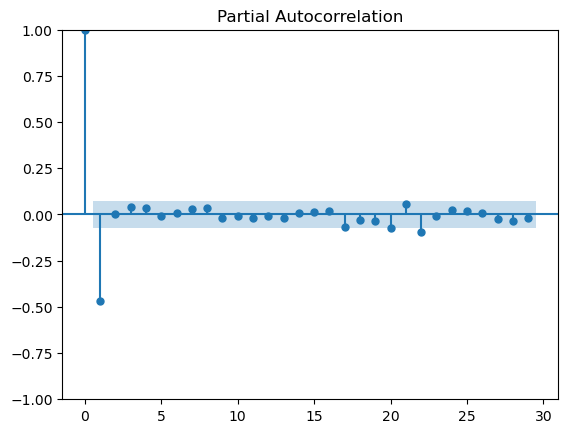

In [12]:
plot_pacf(df_stationarity)

# Spectral Density

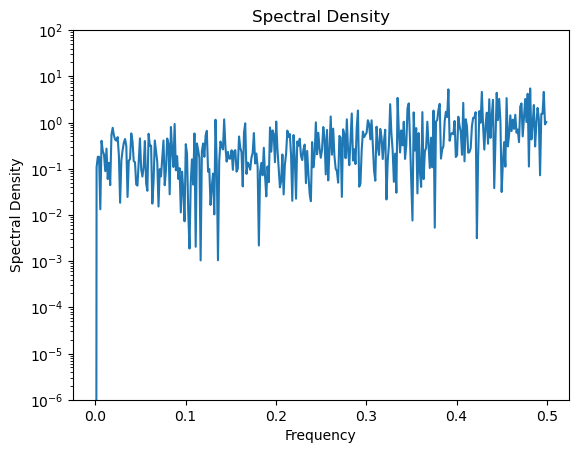

In [13]:
from scipy import signal
f, Pxx = signal.periodogram(df_stationarity['Revenue'])
plt.semilogy(f, Pxx)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()


# Plot decomposition(trend,seasonal,residual) and Residual plot

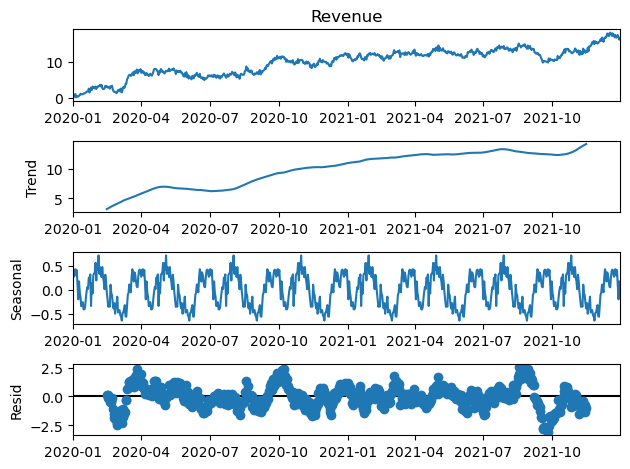

In [14]:
decom.plot() # Plot decomposition 
plt.show() # Check  for seasonality in the data

<AxesSubplot:title={'center':'Residuals'}, xlabel='Date'>

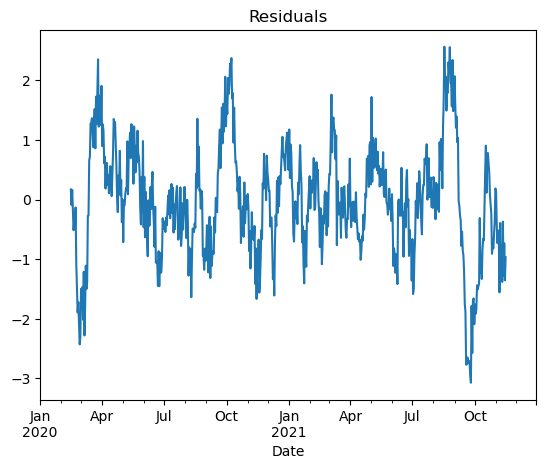

In [15]:
plt.title('Residuals')
decom.resid.plot()


# AUTO ARIMA

In [16]:
from pmdarima.arima import auto_arima
stepwise_fit = auto_arima(df_stationarity,start_p=0,start_q=0,d=1,seasonal=True,trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1945.480, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1379.929, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1943.480, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1221.799, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1153.515, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1126.331, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1104.274, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1102.281, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1124.337, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit t

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  729
Model:               SARIMAX(5, 1, 0)   Log Likelihood                -545.140
Date:                Wed, 21 Jun 2023   AIC                           1102.281
Time:                        10:37:17   BIC                           1129.823
Sample:                    01-02-2020   HQIC                          1112.908
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2959      0.036    -35.739      0.000      -1.367      -1.225
ar.L2         -1.0189      0.057    -17.814      0.000      -1.131      -0.907
ar.L3         -0.7097      0.065    -10.954      0.000      -0.837      -0.583
ar.L4         -0.4272      0.058     -7.306      0.000      -0.542      -0.313
ar.L5         -0.1813      0.037     -4.875      0.000      -0.254      -0.108
sigma2         0.2611      0.015     17.940      0.000       0.233       0.290
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                 3.02
Prob(Q):                              0.42   Prob(JB):                         0.22
Heteroskedasticity (H):               0.99   Skew:                            -0.12
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
model = ARIMA(df_stationarity['Revenue'], order=(5,1,0))
results_ARIMA = model.fit()

In [18]:
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  729
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -545.140
Date:                Wed, 21 Jun 2023   AIC                           1102.281
Time:                        10:37:17   BIC                           1129.823
Sample:                    01-02-2020   HQIC                          1112.908
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2959      0.036    -35.739      0.000      -1.367      -1.225
ar.L2         -1.0189      0.057    -17.814      0.000      -1.131      -0.907
ar.L3         -0.7097      0.065    -10.954      0.0

# SARIMAX Model

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

models = SARIMAX(df_stationarity,order = (5,1,0),seasonal_order = (0,0,0,0),error_action="ignore",supress_warnings = 'true')
results = models.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47809D-01    |proj g|=  3.18292D-03

At iterate    5    f=  7.47792D-01    |proj g|=  7.54162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     10      1     0     0   4.088D-05   7.478D-01
  F =  0.74779210381059136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observati

 This problem is unconstrained.


# prediction results and forcast plot

In [20]:
pred = results.get_prediction(start = -90)
mean_pred = pred.predicted_mean
confidence = pred.conf_int()
lower = confidence.loc[:,'lower Revenue']
upper = confidence.loc[:,'upper Revenue']
print(mean_pred)

2021-10-02    0.071859
2021-10-03    0.018933
2021-10-04   -0.000183
2021-10-05   -0.301127
2021-10-06    0.028698
                ...   
2021-12-26    0.195797
2021-12-27   -0.307364
2021-12-28   -0.282079
2021-12-29    0.232403
2021-12-30    0.154760
Freq: D, Name: predicted_mean, Length: 90, dtype: float64


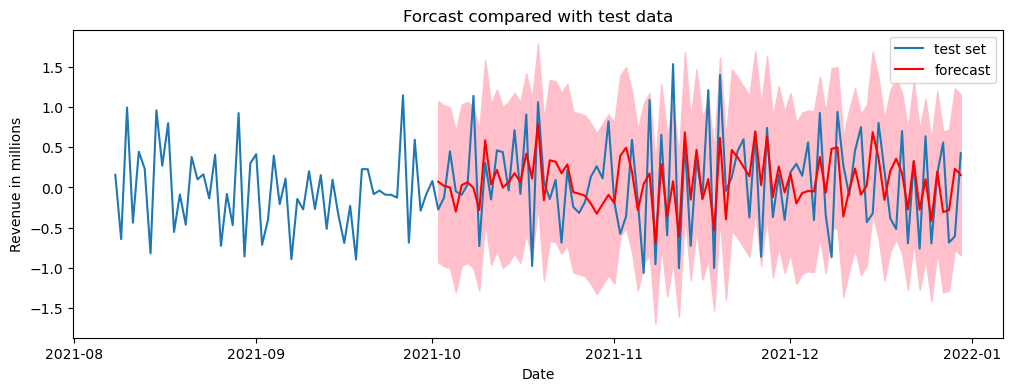

In [21]:
plt.figure(figsize=(12,4))
plt.plot(Xtest.index, Xtest,label='test set')

plt.plot(mean_pred.index, mean_pred,color='r',label='forecast')

plt.fill_between(lower.index,lower,upper,color='pink')


plt.title('Forcast compared with test data')
plt.xlabel('Date')
plt.ylabel('Revenue in millions')
plt.legend()
plt.show()

# Mean Forecast and Revenue forcastd for first quarter in 2022

In [22]:

forecast = results.get_forecast(steps=145)
meanforecast = forecast.predicted_mean
confidence = forecast.conf_int()
lower = confidence.loc[:,'lower Revenue']
upper = confidence.loc[:,'upper Revenue']
print(meanforecast)

2021-12-31   -0.433841
2022-01-01    0.032414
2022-01-02   -0.237616
2022-01-03   -0.208838
2022-01-04   -0.122104
                ...   
2022-05-20   -0.155405
2022-05-21   -0.155405
2022-05-22   -0.155405
2022-05-23   -0.155405
2022-05-24   -0.155405
Freq: D, Name: predicted_mean, Length: 145, dtype: float64


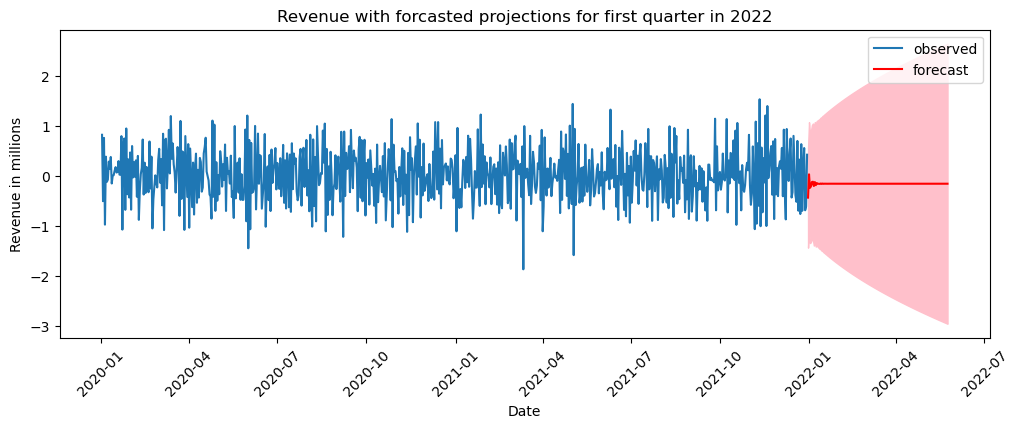

In [23]:
plt.figure(figsize=(12,4))
plt.plot(df_stationarity.index, df_stationarity,label='observed')

plt.plot(meanforecast.index, meanforecast,color='r',label='forecast')

plt.fill_between(lower.index,lower,upper,color='pink')


plt.title('Revenue with forcasted projections for first quarter in 2022')
plt.xlabel('Date')
plt.ylabel('Revenue in millions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Revenue with forcasted projections in first quarter 2022'}, xlabel='Date', ylabel='Revenue in millions'>

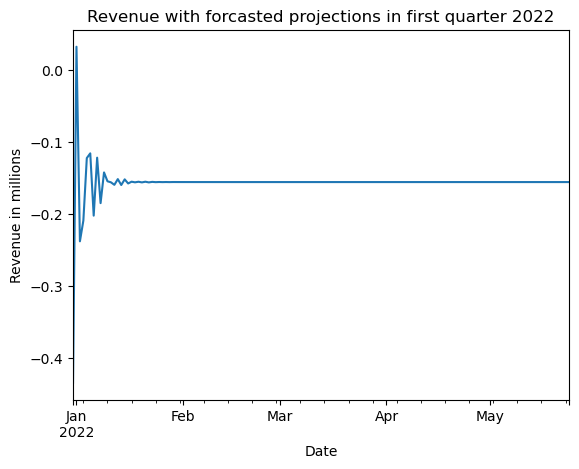

In [24]:
plt.title('Revenue with forcasted projections in first quarter 2022')
plt.xlabel('Date')
plt.ylabel('Revenue in millions')
meanforecast.plot()

# Mean absolute error and Mean squared error

In [26]:
#mean absolute error
mae = np.mean(np.abs(meanforecast.values - Xtest.values))

print("mae is: ",mae)


mae is:  0.4810580360101707


In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Xtest.values, meanforecast.values)

0.48257198038408466

In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Xtest.values, meanforecast.values, squared=True)

0.36066747813288413